# Evalaute Velocity and Direction Dependence
The goal of this notebook is to explore the velocity and direction dependence of stopping power, as predicted by the ML model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lward/mi

## Load TDDFT Data
We need the 100 channel and random direction

In [2]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_traj.pkl')).query('average_range')

In [3]:
random_data = pd.read_pickle(os.path.join('data', 'random_traj.pkl'))

## Load the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [4]:
model = keras.models.load_model('model-random-and-channel.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [6]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 15        
__________

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [8]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Evaluate $\left<100\right>$ at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [9]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [10]:
%%time
velocities = np.linspace(0.1, 8, 32)
stopping_power = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [1, 0, 0], v)[0]
    for v in velocities
]

CPU times: user 12.1 s, sys: 12.5 s, total: 24.6 s
Wall time: 8.16 s


## Run the Random Trajectory at Many Velocities
We are going to compute the average stopping power by evaluating the stopping force at every position along the trajectory with different speeds

In [11]:
random_stopping = []
for gid, group in random_data.groupby('directory'):
    random_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
random_stopping = pd.DataFrame(random_stopping)

In [12]:
def compute_random_stopping_power(speed: float) -> float:
    """Compute the stopping power for the random trajectory
    
    Args:
        speed: Magnitude of the velocity
    Returns:
        Stopping power
    """
    
    # Get the positions along the trajectory
    random_positions = random_data[random_data['file'].str.contains('Dv1.0')].copy()
    
    # Update the velocity
    random_positions['velocity'] *= speed
    
    # Run the model
    featurizers.set_chunksize(None)
    x = featurizers.featurize_many(random_positions[['position', 'velocity']], pbar=False)
    forces = model.predict(np.array(x))
    return forces.mean()

In [13]:
%%time
stopping_power_random = [
    compute_random_stopping_power(v)
    for v in velocities
]

CPU times: user 1min 8s, sys: 1min 29s, total: 2min 38s
Wall time: 8min 3s


## Plot both together
Show how the stopping powers on and off channels change differently as a function of velocity

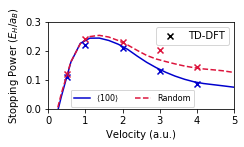

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ch, = ax.plot(velocities, stopping_power, color='mediumblue', label='Channel')
och, = ax.plot(velocities, stopping_power_random, '--', color='crimson', label='Off Channel')

# Add in the points for the channel
tddft = ax.scatter([], [], marker='x', facecolor='k', edgecolor='k', label='TD-DFT')
ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
                   facecolor='mediumblue', edgecolor='mediumblue', label='TD-DFT')
ax.scatter(random_stopping['velocity'], random_stopping['stopping'], marker='x',
                   facecolor='crimson', edgecolor='crimson', label='TD-DFT')

ax.set_xlabel('Velocity (a.u.)')
ax.set_ylabel('Stopping Power ($E_H / a_B$)')
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 5)

l1 = ax.legend((ch, och), ('$\\left<100\\right>$', 'Random'), loc=(0.12, 0.02), ncol=2, fontsize=8)
ax.add_artist(l1)
ax.legend((tddft,), ('TD-DFT',))

fig.tight_layout()
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.png'), dpi=320)
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.pdf'))

*Finding*: The stopping power doesn't go to (0, 0), and does seem like it will converge to 0. But, the model does capture that the low velocity regime is linear and the difference between the channel and off chanell gets bigger at higher velocities before merging again at very high velocities.

Save the stopping power for the channels

In [17]:
channel_stopping.to_csv('stopping_power-100.csv', index=False)